In [1]:
import os,torch
from torch import nn
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from vis_utils import show_img_batch
%matplotlib inline

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
mnist = MNIST(root="../Data/", download=False, 
              transform=transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize((0.5,), (0.5,))]))
mnist_dl = DataLoader(mnist, batch_size=128, shuffle=True)

In [4]:
class GenConvTransposeBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, final=False):
        super().__init__()
        if not final:
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_channels, 
                                   out_channels=out_channels, 
                                   kernel_size=kernel_size,
                                   stride=stride),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_channels, 
                                   out_channels=out_channels, 
                                   kernel_size= kernel_size, 
                                   stride=stride),
                nn.Tanh()
            )

    def forward(self, x):
        return self.block(x)

In [5]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super().__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            GenConvTransposeBlock(z_dim, hidden_dim * 4),
            GenConvTransposeBlock(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            GenConvTransposeBlock(hidden_dim * 2, hidden_dim * 1),
            GenConvTransposeBlock(hidden_dim * 1, im_chan,  kernel_size=4, final=True)
        )

    def unsqueeze_noise(self, x):
        return x.view(len(x), self.z_dim, 1, 1)
    
    def forward(self, x):
        x = self.unsqueeze_noise(x)
        return self.gen(x)

In [6]:
def get_noise(n_samples, z_dim, device):
    return torch.randn((n_samples, z_dim), device=device)

In [7]:
class DiscConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, final=False):
        super().__init__()
        if not final:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, 
                          out_channels=out_channels, 
                          kernel_size=kernel_size,
                          stride=stride),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, 
                          out_channels=out_channels, 
                          kernel_size= kernel_size, 
                          stride=stride),
            )

    def forward(self, x):
        return self.block(x)

In [8]:
class Critic(nn.Module):

    def __init__(self, im_chan=1, hidden_dim=64):
        super().__init__()
        self.crit = nn.Sequential(
            DiscConvBlock(im_chan, hidden_dim * 1),
            DiscConvBlock(hidden_dim * 1, hidden_dim * 2),
            DiscConvBlock(hidden_dim * 2, 1, final=True),
        )

    def forward(self, x):
        return self.crit(x).view(-1, 1)

In [9]:
n_samples = 100
z_dim = 10
hidden_dim = 64
noise_input = get_noise(n_samples, z_dim, device)
real = next(iter(mnist_dl))[0].to(device)
gen = Generator(z_dim=z_dim, im_chan=1, hidden_dim=64).to(device)
fake = gen(noise_input)
crit = Critic(1, 64).to(device)

In [15]:
epsilon = torch.rand(fake.shape[:2], device=device)[:,:,None,None]
mixed = epsilon * fake + (1-epsilon) * real
score = crit(mixed)

In [39]:
def get_gradient(crit, real, fake, epsilon):

    mixed = (1-epsilon) * fake + epsilon * real
    score = crit(mixed)
    return torch.autograd.grad(
         outputs = score, 
         inputs = mixed, 
         grad_outputs=torch.ones_like(score), 
         retain_graph=True, 
         create_graph=True
         )[0]

In [45]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: gradient_penalty
def gradient_penalty_(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean((gradient_norm - 1)**2)
    #### END CODE HERE ####
    return penalty

In [46]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1 )
    grad_norm = gradient.norm(2, dim=1)
    return torch.mean(torch.square(grad_norm-1))

## Training

In [21]:

n_epochs = 100
z_dim = 64
display_step = 2500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'mps' if torch.backends.mps.is_available() else "cpu"

In [51]:
# Initialize the generator and discriminator

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),   lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))


def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

 33%|███▎      | 155/469 [00:35<01:10,  4.43it/s]

Epoch 5, step 2500: Generator loss: -14.39, discriminator loss: -253.50


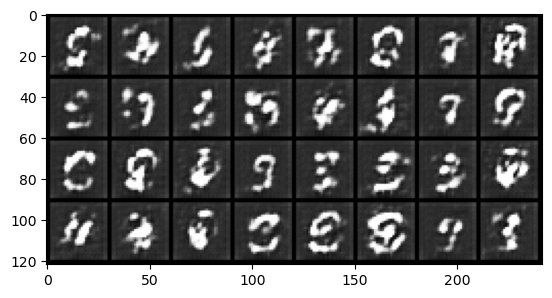

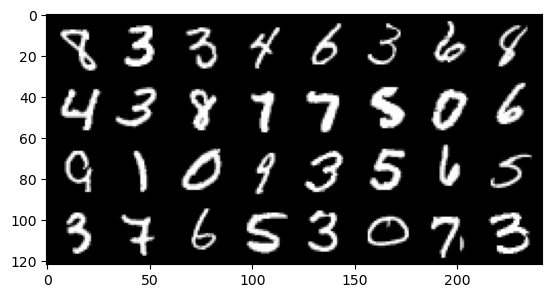

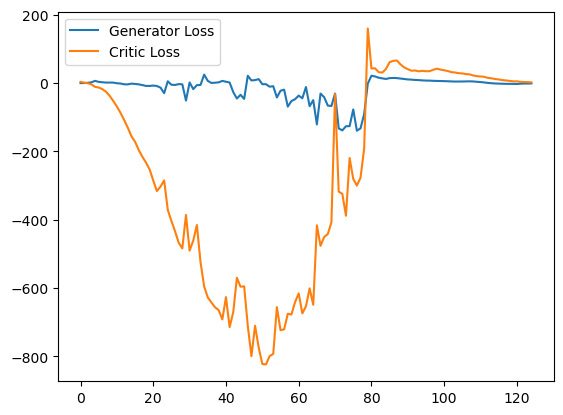

 66%|██████▌   | 310/469 [01:09<00:36,  4.41it/s]

Epoch 10, step 5000: Generator loss: -12.59, discriminator loss: -11.09


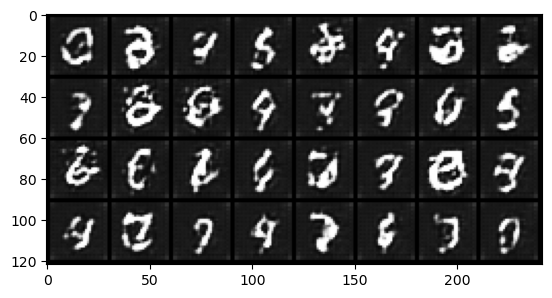

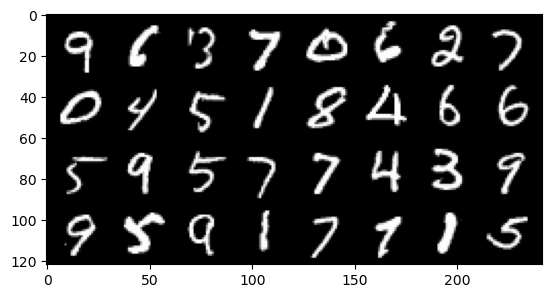

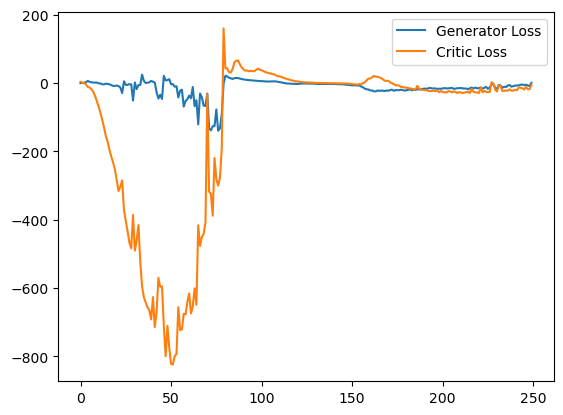

 99%|█████████▉| 465/469 [01:44<00:00,  4.40it/s]

Epoch 15, step 7500: Generator loss: 8.05, discriminator loss: -5.10


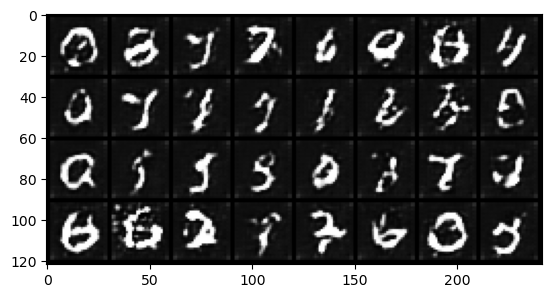

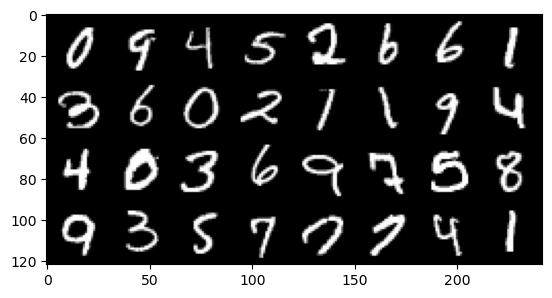

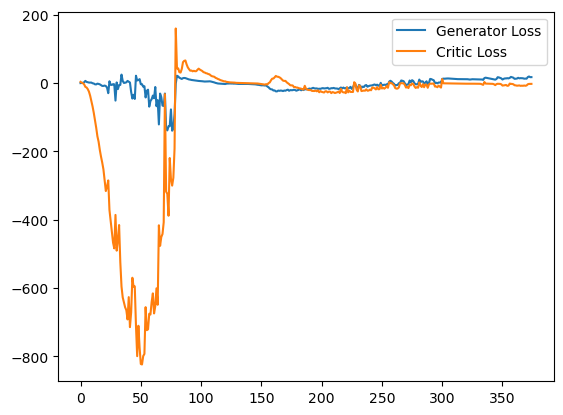

 32%|███▏      | 151/469 [00:33<01:10,  4.48it/s]

Epoch 21, step 10000: Generator loss: 17.86, discriminator loss: -5.79


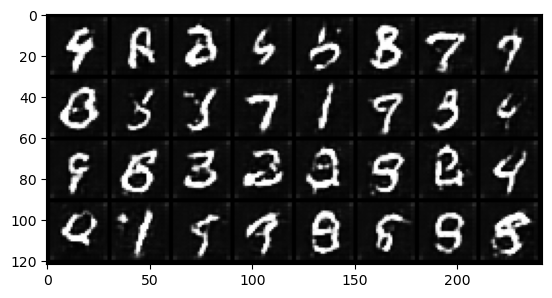

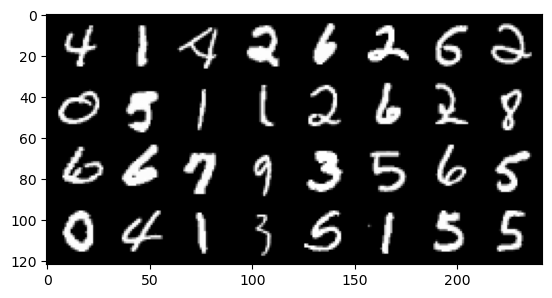

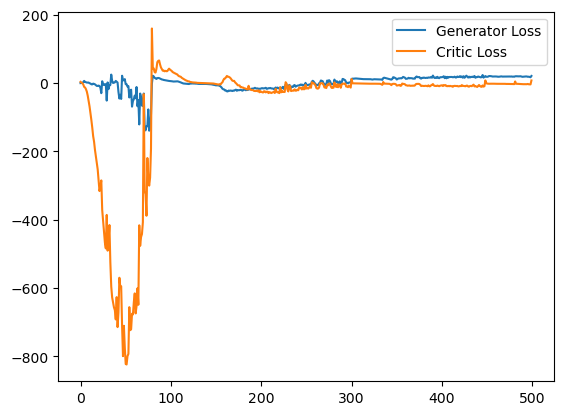

 65%|██████▌   | 306/469 [01:09<00:37,  4.37it/s]

Epoch 26, step 12500: Generator loss: 18.81, discriminator loss: -7.53


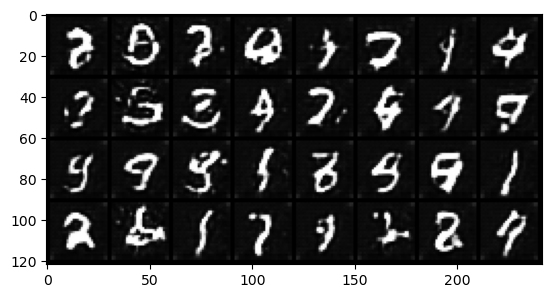

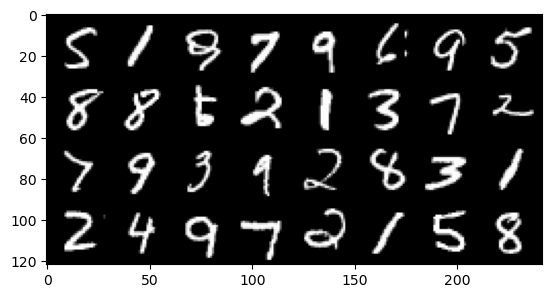

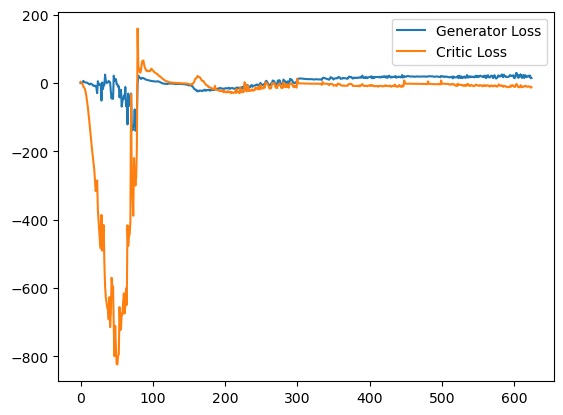

 98%|█████████▊| 461/469 [01:43<00:01,  4.43it/s]

Epoch 31, step 15000: Generator loss: 24.57, discriminator loss: -11.46


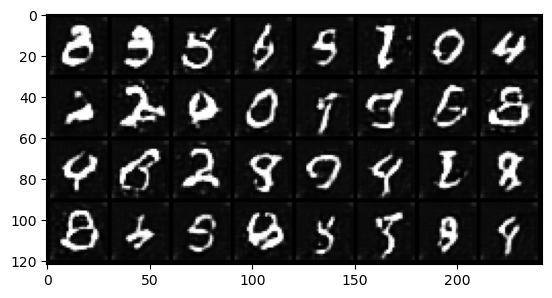

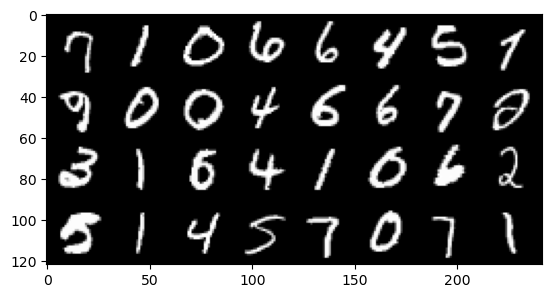

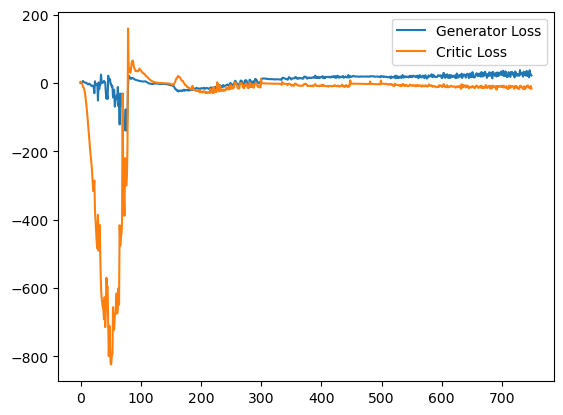

 31%|███▏      | 147/469 [00:33<01:12,  4.47it/s]

Epoch 37, step 17500: Generator loss: 34.42, discriminator loss: -12.31


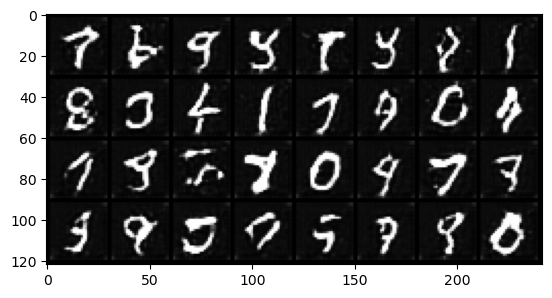

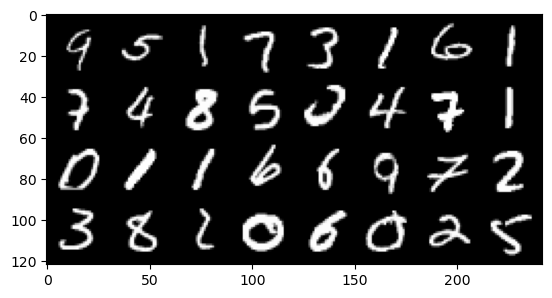

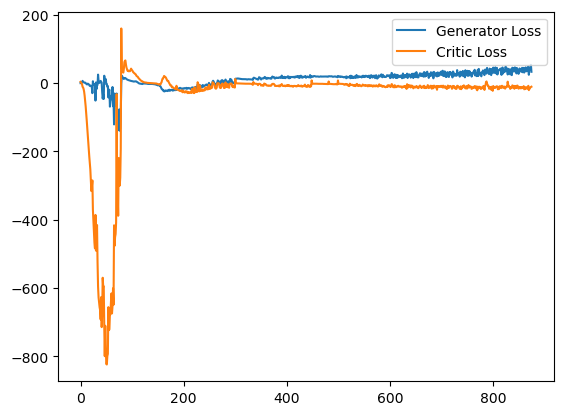

 64%|██████▍   | 302/469 [01:07<00:37,  4.42it/s]

Epoch 42, step 20000: Generator loss: 40.64, discriminator loss: -13.10


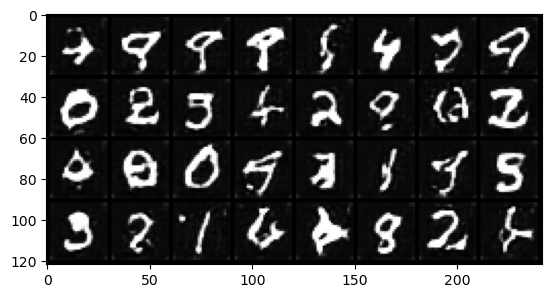

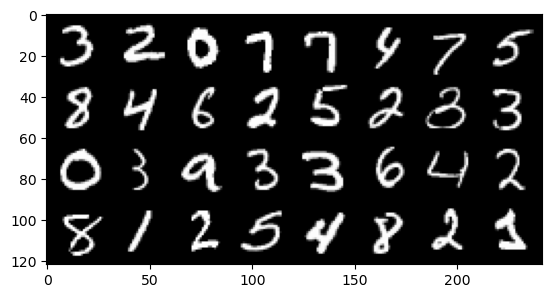

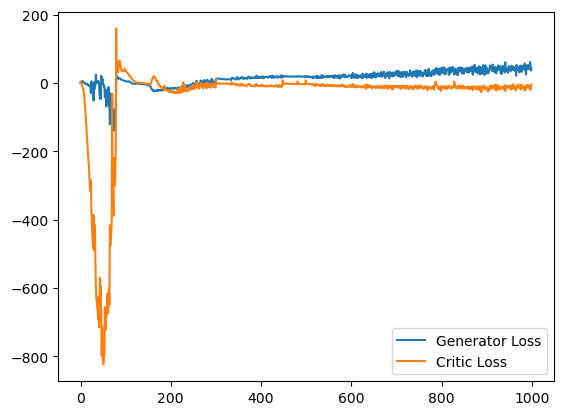

 97%|█████████▋| 457/469 [01:43<00:02,  4.43it/s]

Epoch 47, step 22500: Generator loss: 45.54, discriminator loss: -14.42


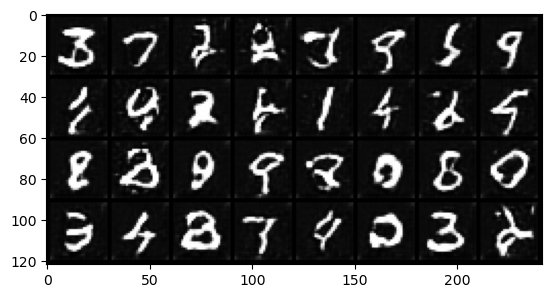

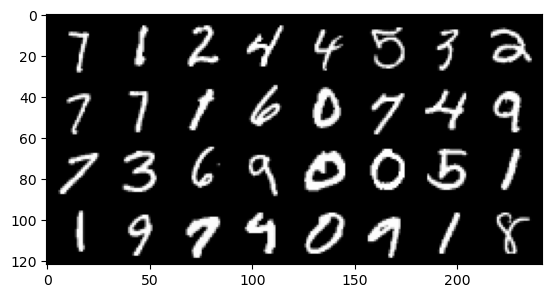

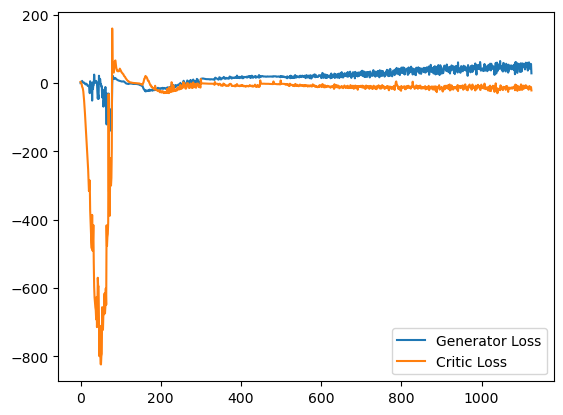

100%|██████████| 469/469 [01:45<00:00,  4.45it/s]


In [53]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_critic_loss = 0
generator_losses = []
critic_losses = []

for epoch in range(n_epochs):

    for real, _ in tqdm(mnist_dl):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for k in range(crit_repeats):
            ## Update discriminator ##
            crit_opt.zero_grad()
            
            # Get noise corresponding to the current batch_size
            noise = get_noise(cur_batch_size, z_dim, device=device)
                    
            fake = gen(noise)
            crit_fake = crit(fake.detach())
            crit_real = crit(real)
            
            epsilon = torch.rand(len(fake), fake.shape[1], 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            grad_pen = gradient_penalty(gradient)

            crit_loss = torch.mean(crit_fake) - torch.mean(crit_real) + c_lambda*grad_pen
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats

            crit_loss.backward(retain_graph=True)
            crit_opt.step()

        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        noise = get_noise(cur_batch_size, z_dim, device=device)
                
        fake = gen(noise)
        gen_fake = crit(fake)
        gen_fake_loss = - torch.mean(gen_fake)
        gen_fake_loss.backward()
        gen_opt.step()        
        
        # Keep track of the average generator loss
        generator_losses += [gen_fake_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean:.2f}, discriminator loss: {crit_mean:.2f}")
            show_img_batch((fake + 1) / 2)
            show_img_batch((real + 1) / 2)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()
        cur_step += 1

In [63]:
torch.save({
    'gen_state': gen.state_dict(), 
    'gen_opt_state': gen_opt.state_dict(),
    'crit_state': crit.state_dict(),
    'crit_opt_state': crit_opt.state_dict()
    }, 
    'wgan_dp.pth'
)